# Comprehensive Model Analysis & Comparison
## Learning Progress Prediction - DataFlow 2026

**Notebook này bao gồm:**
1. Feature Importance Analysis
2. LIME - Local Interpretable Model-agnostic Explanations
3. SHAP - SHapley Additive exPlanations
4. Model Comparison (LightGBM, CatBoost, XGBoost, Ensemble)
5. Stacking Ensemble với Meta-Learner (Ridge Regression)
6. Hyperparameter Optimization với Optuna
7. Complete Training Pipeline

## 1. Setup & Data Loading

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent.parent))

# ML libraries
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Interpretability libraries
import shap
import lime
import lime.lime_tabular

# Optimization
import optuna
from optuna.samplers import TPESampler

# Custom modules
from src.config import RANDOM_STATE
from src.utils import set_seed
from src.data_loader import load_and_prepare_data
from src.features import prepare_features_for_modeling, FeatureEngineer
from src.evaluation import calculate_metrics, print_metrics

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
set_seed(RANDOM_STATE)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')



In [41]:
train_feat = pd.read_csv('../../data/processed/train_final.csv')
test_feat = pd.read_csv('../../data/processedtest_final.csv')
    
# Giả sử bạn dùng 1 phần train làm validation hoặc đã có valid_final.csv
# Ở đây tôi ví dụ tách validation từ train nếu bạn chưa có file valid riêng
from sklearn.model_selection import train_test_split
train_feat, valid_feat = train_test_split(train_feat, test_size=0.2, random_state=RANDOM_STATE)

# Khởi tạo Engineer để lấy danh sách cột hợp lệ
engineer = FeatureEngineer()
feature_cols = engineer.get_feature_columns(train_feat)
categorical_cols = [c for c in feature_cols if c in engineer.cat_cols]
    
target_col = 'COMPLETION_RATE' # Hoặc 'TC_HOANTHANH' tùy mục tiêu của bạn

# Prepare X, y
X_train = train_feat[feature_cols].copy()
y_train = train_feat[target_col]
X_valid = valid_feat[feature_cols].copy()
y_valid = valid_feat[target_col]
X_test = test_feat[feature_cols].copy()
# Encode categorical columns nếu cần
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
if categorical_cols:
    X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols].astype(str))
    X_valid[categorical_cols] = encoder.transform(X_valid[categorical_cols].astype(str))
    X_test[categorical_cols] = encoder.transform(X_test[categorical_cols].astype(str))
# Gán lại các biến cần thiết cho các bước sau
valid_full_df = valid_feat
test_full_df = test_feat

In [42]:
# ==============================
# Feature engineering (FINAL)
# ==============================

print("Features already prepared from previous cell")

# X, y đã được tạo + encode ở cell trước
# Chỉ cần gán lại cho thống nhất pipeline

X_train_final = X_train.copy()
X_valid_final = X_valid.copy()
y_train_final = y_train.copy()
y_valid_final = y_valid.copy()
X_test_final  = X_test.copy() if X_test is not None else None

# Credits cho evaluation
valid_credits_dangky = valid_feat['TC_DANGKY'].values
y_valid_credits = valid_feat['TC_HOANTHANH'].values

print(f"\n✓ Features ready: {X_train_final.shape[1]} features")
print(f"  Categorical (encoded): {len(categorical_cols)}")
print(f"  Numerical: {X_train_final.shape[1] - len(categorical_cols)}")

# Sanity check dtype (rất quan trọng cho XGBoost)
print("\nDtype check:")
print(X_train_final.dtypes.value_counts())


Features already prepared from previous cell

✓ Features ready: 24 features
  Categorical (encoded): 2
  Numerical: 22

Dtype check:
float64    18
int64       6
Name: count, dtype: int64


## 2. Feature Importance Analysis

In [43]:
def plot_feature_importance_comparison(models_dict, feature_names, top_n=20):
    """
    So sánh feature importance của nhiều models
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.ravel()
    
    for idx, (name, model) in enumerate(models_dict.items()):
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        else:
            continue
            
        # Create DataFrame
        imp_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False).head(top_n)
        
        # Plot
        sns.barplot(data=imp_df, y='feature', x='importance', ax=axes[idx], palette='viridis')
        axes[idx].set_title(f'{name} - Top {top_n} Features', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Importance', fontsize=12)
        axes[idx].set_ylabel('')
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('output/evaluation/feature_importance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return imp_df

print("Feature importance analysis will be performed after model training")

Feature importance analysis will be performed after model training


## 3. Model Training & Comparison

In [44]:
# Prepare categorical features for each model type
from sklearn.preprocessing import LabelEncoder

# For models that need encoding
X_train_encoded = X_train.copy()
X_valid_encoded = X_valid.copy()

label_encoders = {}
for col in categorical_cols:
    if col in X_train_encoded.columns:
        le = LabelEncoder()
        X_train_encoded[col] = le.fit_transform(X_train_encoded[col].astype(str))
        X_valid_encoded[col] = le.transform(X_valid_encoded[col].astype(str))
        label_encoders[col] = le

# For XGBoost - categorical dtype
X_train_xgb = X_train.copy()
X_valid_xgb = X_valid.copy()
for col in categorical_cols:
    if col in X_train_xgb.columns:
        X_train_xgb[col] = X_train_xgb[col].astype('category')
        X_valid_xgb[col] = X_valid_xgb[col].astype('category')

# For CatBoost - string dtype
X_train_cb = X_train.copy()
X_valid_cb = X_valid.copy()
for col in categorical_cols:
    if col in X_train_cb.columns:
        X_train_cb[col] = X_train_cb[col].astype(str)
        X_valid_cb[col] = X_valid_cb[col].astype(str)

cat_features = [i for i, col in enumerate(X_train.columns) if col in categorical_cols]

print("✓ Data prepared for all model types")

✓ Data prepared for all model types


### 3.1 Train Individual Models

In [107]:
# Dictionary to store all models and results
models = {}
predictions = {}
results = []

def evaluate_model(name, y_pred_rate, y_valid_credits, valid_credits_dangky):
    """Evaluate model predictions"""
    # Post-processing
    y_pred_rate = np.clip(y_pred_rate, 0, 1)
    y_pred_credits = y_pred_rate * valid_credits_dangky
    y_pred_credits = np.minimum(y_pred_credits, valid_credits_dangky)
    
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_valid_credits, y_pred_credits))
    mae = mean_absolute_error(y_valid_credits, y_pred_credits)
    r2 = r2_score(y_valid_credits, y_pred_credits)
    
    # Accuracy within 1 credit
    acc_1 = np.mean(np.abs(y_valid_credits - y_pred_credits) < 1) * 100
    
    return {
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Accuracy': acc_1
    }, y_pred_credits

In [108]:
# 1. XGBoost
print("\n" + "="*60)
print("Training XGBoost...")
print("="*60)

xgb_params = {
    'n_estimators': 2000,
    'learning_rate': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'random_state': RANDOM_STATE,
    'enable_categorical': True,
    'tree_method': 'hist',
}

xgb_model = xgb.XGBRegressor(**xgb_params)

xgb_model.fit(
    X=X_train_final,
    y=y_train_final,
    eval_set=[(X_valid_final, y_valid_final)],
    verbose=200
)

models['XGBoost'] = xgb_model
y_pred_xgb = xgb_model.predict(X_valid_xgb)
result, pred_credits = evaluate_model('XGBoost', y_pred_xgb, y_valid_credits, valid_credits_dangky)
results.append(result)
predictions['XGBoost'] = pred_credits

print(f"\nXGBoost Results:")
print(f"  RMSE: {result['RMSE']:.4f}")
print(f"  MAE:  {result['MAE']:.4f}")
print(f"  R2:   {result['R2']:.4f}")
print(f"  Accuracy: {result['Accuracy']:.2f}%")


Training XGBoost...
[0]	validation_0-rmse:0.25907
[200]	validation_0-rmse:0.19613
[400]	validation_0-rmse:0.19401
[600]	validation_0-rmse:0.19329
[800]	validation_0-rmse:0.19286
[1000]	validation_0-rmse:0.19261
[1200]	validation_0-rmse:0.19255
[1400]	validation_0-rmse:0.19249
[1600]	validation_0-rmse:0.19247
[1800]	validation_0-rmse:0.19247
[1999]	validation_0-rmse:0.19249

XGBoost Results:
  RMSE: 3.6773
  MAE:  2.5235
  R2:   0.6977
  Accuracy: 33.00%


In [109]:
# 2. LightGBM
print("\n" + "="*60)
print("Training LightGBM...")
print("="*60)

lgb_params = {
    'n_estimators': 2000,
    'learning_rate': 0.02,
    'max_depth': 6,
    'num_leaves': 31,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,
    'reg_lambda': 1.0,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbose': -1
}

lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb_model.fit(
    X_train_encoded, y_train,
    eval_set=[(X_train_encoded, y_train), (X_valid_encoded, y_valid)],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(200)]
)

models['LightGBM'] = lgb_model
y_pred_lgb = lgb_model.predict(X_valid_encoded)
result, pred_credits = evaluate_model('LightGBM', y_pred_lgb, y_valid_credits, valid_credits_dangky)
results.append(result)
predictions['LightGBM'] = pred_credits

print(f"\nLightGBM Results:")
print(f"  RMSE: {result['RMSE']:.4f}")
print(f"  MAE:  {result['MAE']:.4f}")
print(f"  R2:   {result['R2']:.4f}")
print(f"  Accuracy: {result['Accuracy']:.2f}%")


Training LightGBM...
Training until validation scores don't improve for 50 rounds
[200]	training's l2: 0.0379642	valid_1's l2: 0.03866
[400]	training's l2: 0.0364726	valid_1's l2: 0.0378584
[600]	training's l2: 0.0354687	valid_1's l2: 0.0374764
[800]	training's l2: 0.0345786	valid_1's l2: 0.0372586
[1000]	training's l2: 0.0338322	valid_1's l2: 0.0371325
[1200]	training's l2: 0.0331734	valid_1's l2: 0.0370526
Early stopping, best iteration is:
[1231]	training's l2: 0.0330778	valid_1's l2: 0.0370497

LightGBM Results:
  RMSE: 3.6789
  MAE:  2.5387
  R2:   0.6975
  Accuracy: 32.31%


In [110]:
# 3. CatBoost
print("\n" + "="*60)
print("Training CatBoost...")
print("="*60)

cat_params = {
    'iterations': 2000,
    'learning_rate': 0.02,
    'depth': 6,
    'l2_leaf_reg': 3.0,
    'random_state': RANDOM_STATE,
    'verbose': 200,
    'thread_count': -1
}

cat_model = cb.CatBoostRegressor(**cat_params)
cat_model.fit(
    X_train_cb, y_train,
    cat_features=cat_features,
    eval_set=(X_valid_cb, y_valid),
    early_stopping_rounds=50
)

models['CatBoost'] = cat_model
y_pred_cat = cat_model.predict(X_valid_cb)
result, pred_credits = evaluate_model('CatBoost', y_pred_cat, y_valid_credits, valid_credits_dangky)
results.append(result)
predictions['CatBoost'] = pred_credits

print(f"\nCatBoost Results:")
print(f"  RMSE: {result['RMSE']:.4f}")
print(f"  MAE:  {result['MAE']:.4f}")
print(f"  R2:   {result['R2']:.4f}")
print(f"  Accuracy: {result['Accuracy']:.2f}%")


Training CatBoost...
0:	learn: 0.2579201	test: 0.2591389	best: 0.2591389 (0)	total: 50.9ms	remaining: 1m 41s
200:	learn: 0.1988863	test: 0.1989980	best: 0.1989980 (200)	total: 10.7s	remaining: 1m 35s
400:	learn: 0.1955843	test: 0.1962286	best: 0.1962286 (400)	total: 21s	remaining: 1m 23s
600:	learn: 0.1936936	test: 0.1950760	best: 0.1950760 (600)	total: 36.7s	remaining: 1m 25s
800:	learn: 0.1922155	test: 0.1944766	best: 0.1944766 (800)	total: 50.8s	remaining: 1m 16s
1000:	learn: 0.1909417	test: 0.1940003	best: 0.1939997 (999)	total: 1m 3s	remaining: 1m 3s
1200:	learn: 0.1898586	test: 0.1936980	best: 0.1936980 (1200)	total: 1m 15s	remaining: 50.4s
1400:	learn: 0.1888318	test: 0.1933973	best: 0.1933964 (1399)	total: 1m 27s	remaining: 37.5s
1600:	learn: 0.1878759	test: 0.1931502	best: 0.1931502 (1600)	total: 1m 39s	remaining: 24.8s
1800:	learn: 0.1870191	test: 0.1929707	best: 0.1929707 (1798)	total: 1m 51s	remaining: 12.3s
1999:	learn: 0.1862140	test: 0.1928090	best: 0.1928081 (1998)	tot

### 3.2 Simple Ensemble (Weighted Average)

In [111]:
print("\n" + "="*60)
print("Creating Simple Ensemble (Weighted Average)...")
print("="*60)

# Weighted average of predictions
weights = {'XGBoost': 0.4, 'LightGBM': 0.3, 'CatBoost': 0.3}

y_pred_ensemble = (
    weights['XGBoost'] * y_pred_xgb +
    weights['LightGBM'] * y_pred_lgb +
    weights['CatBoost'] * y_pred_cat
)

result, pred_credits = evaluate_model('Simple Ensemble', y_pred_ensemble, y_valid_credits, valid_credits_dangky)
results.append(result)
predictions['Simple Ensemble'] = pred_credits

print(f"\nSimple Ensemble Results:")
print(f"  Weights: {weights}")
print(f"  RMSE: {result['RMSE']:.4f}")
print(f"  MAE:  {result['MAE']:.4f}")
print(f"  R2:   {result['R2']:.4f}")
print(f"  Accuracy: {result['Accuracy']:.2f}%")


Creating Simple Ensemble (Weighted Average)...

Simple Ensemble Results:
  Weights: {'XGBoost': 0.4, 'LightGBM': 0.3, 'CatBoost': 0.3}
  RMSE: 3.6696
  MAE:  2.5288
  R2:   0.6990
  Accuracy: 32.53%


### 3.3 Stacking Ensemble with Ridge Meta-Learner

In [112]:
print("\n" + "="*60)
print("Training Blending Ensemble (XGB + LGB + CatBoost)")
print("="*60)
# XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Training XGBoost...")
xgb_model.fit(X_train_final, y_train_final)

# LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=6,
    num_leaves=31,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

print("Training LightGBM...")
lgb_model.fit(X_train_final, y_train_final)

# CatBoost
cat_model = cb.CatBoostRegressor(
    iterations=1000,
    learning_rate=0.02,
    depth=6,
    random_state=RANDOM_STATE,
    verbose=False
)

print("Training CatBoost...")
cat_model.fit(X_train_final, y_train_final)

# Lưu model
models['XGBoost'] = xgb_model
models['LightGBM'] = lgb_model
models['CatBoost'] = cat_model
print("\nPredicting on validation set...")

pred_xgb = xgb_model.predict(X_valid_final)
pred_lgb = lgb_model.predict(X_valid_final)
pred_cat = cat_model.predict(X_valid_final)
from sklearn.linear_model import Ridge
import numpy as np

P = np.column_stack([pred_xgb, pred_lgb, pred_cat])

# Ridge không intercept để học đúng trọng số
ridge = Ridge(alpha=1.0, fit_intercept=False)
ridge.fit(P, y_valid_final)

raw_weights = ridge.coef_
weights = raw_weights / raw_weights.sum()

print("\nOptimal blending weights:")
print(f"  XGBoost : {weights[0]:.3f}")
print(f"  LightGBM: {weights[1]:.3f}")
print(f"  CatBoost: {weights[2]:.3f}")
y_pred_blend = P @ weights
result, pred_credits = evaluate_model(
    'Blending (XGB + LGB + CatBoost)',
    y_pred_blend,
    y_valid_credits,
    valid_credits_dangky
)

results.append(result)
predictions['Blending'] = pred_credits

print(f"\nBlending Ensemble Results:")
print(f"  Models: XGBoost + LightGBM + CatBoost")
print(f"  RMSE: {result['RMSE']:.4f}")
print(f"  MAE:  {result['MAE']:.4f}")
print(f"  R2:   {result['R2']:.4f}")
print(f"  Accuracy: {result['Accuracy']:.2f}%")



Training Blending Ensemble (XGB + LGB + CatBoost)
Training XGBoost...
Training LightGBM...
Training CatBoost...

Predicting on validation set...

Optimal blending weights:
  XGBoost : 0.617
  LightGBM: 0.347
  CatBoost: 0.036

Blending Ensemble Results:
  Models: XGBoost + LightGBM + CatBoost
  RMSE: 3.6793
  MAE:  2.5407
  R2:   0.6974
  Accuracy: 32.16%


### 3.4 Results Comparison Table


MODEL COMPARISON - VALIDATION SET (NO RANDOM FOREST)
                          Model     RMSE      MAE       R2  Accuracy
                Simple Ensemble 3.669588 2.528791 0.699012 32.526246
                        XGBoost 3.677320 2.523515 0.697743 32.999149
                       LightGBM 3.678851 2.538735 0.697491 32.313440
Blending (XGB + LGB + CatBoost) 3.679324 2.540667 0.697413 32.157382
                       CatBoost 3.684645 2.544797 0.696537 32.242504

 Results saved to: output/evaluation/model_comparison_results.csv


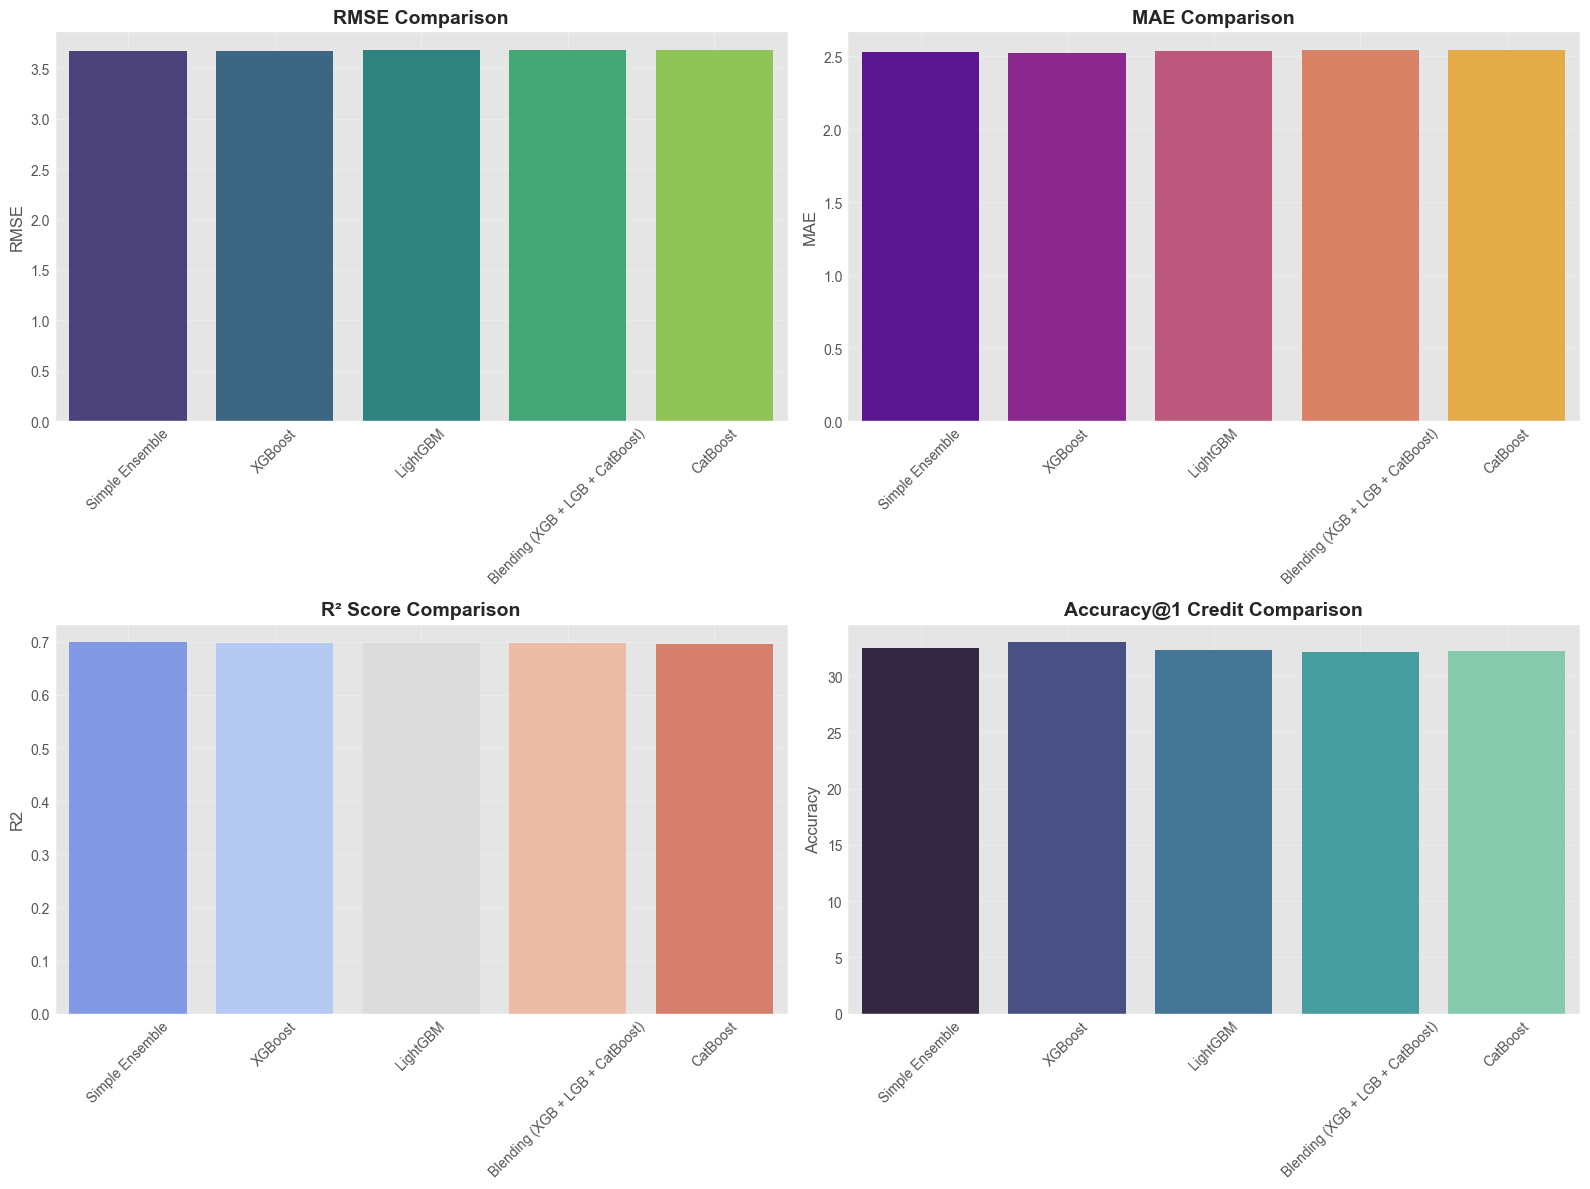


✓ Comparison charts saved to: output/evaluation/model_comparison_charts.png


In [113]:
import os
os.makedirs('output/evaluation', exist_ok=True)

results_df = pd.DataFrame(results)

results_df = results_df[~results_df['Model'].str.contains('RandomForest|RF', case=False)]

results_df = results_df.sort_values('RMSE')

print("\n" + "="*80)
print("MODEL COMPARISON - VALIDATION SET (NO RANDOM FOREST)")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

results_df.to_csv('output/evaluation/model_comparison_results.csv', index=False)
print("\n Results saved to: output/evaluation/model_comparison_results.csv")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RMSE comparison
sns.barplot(data=results_df, x='Model', y='RMSE', ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# MAE comparison
sns.barplot(data=results_df, x='Model', y='MAE', ax=axes[0, 1], palette='plasma')
axes[0, 1].set_title('MAE Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# R2 comparison
sns.barplot(data=results_df, x='Model', y='R2', ax=axes[1, 0], palette='coolwarm')
axes[1, 0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Accuracy comparison
sns.barplot(data=results_df, x='Model', y='Accuracy', ax=axes[1, 1], palette='mako')
axes[1, 1].set_title('Accuracy@1 Credit Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/evaluation/model_comparison_charts.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparison charts saved to: output/evaluation/model_comparison_charts.png")


## 4. Feature Importance Analysis (All Models)

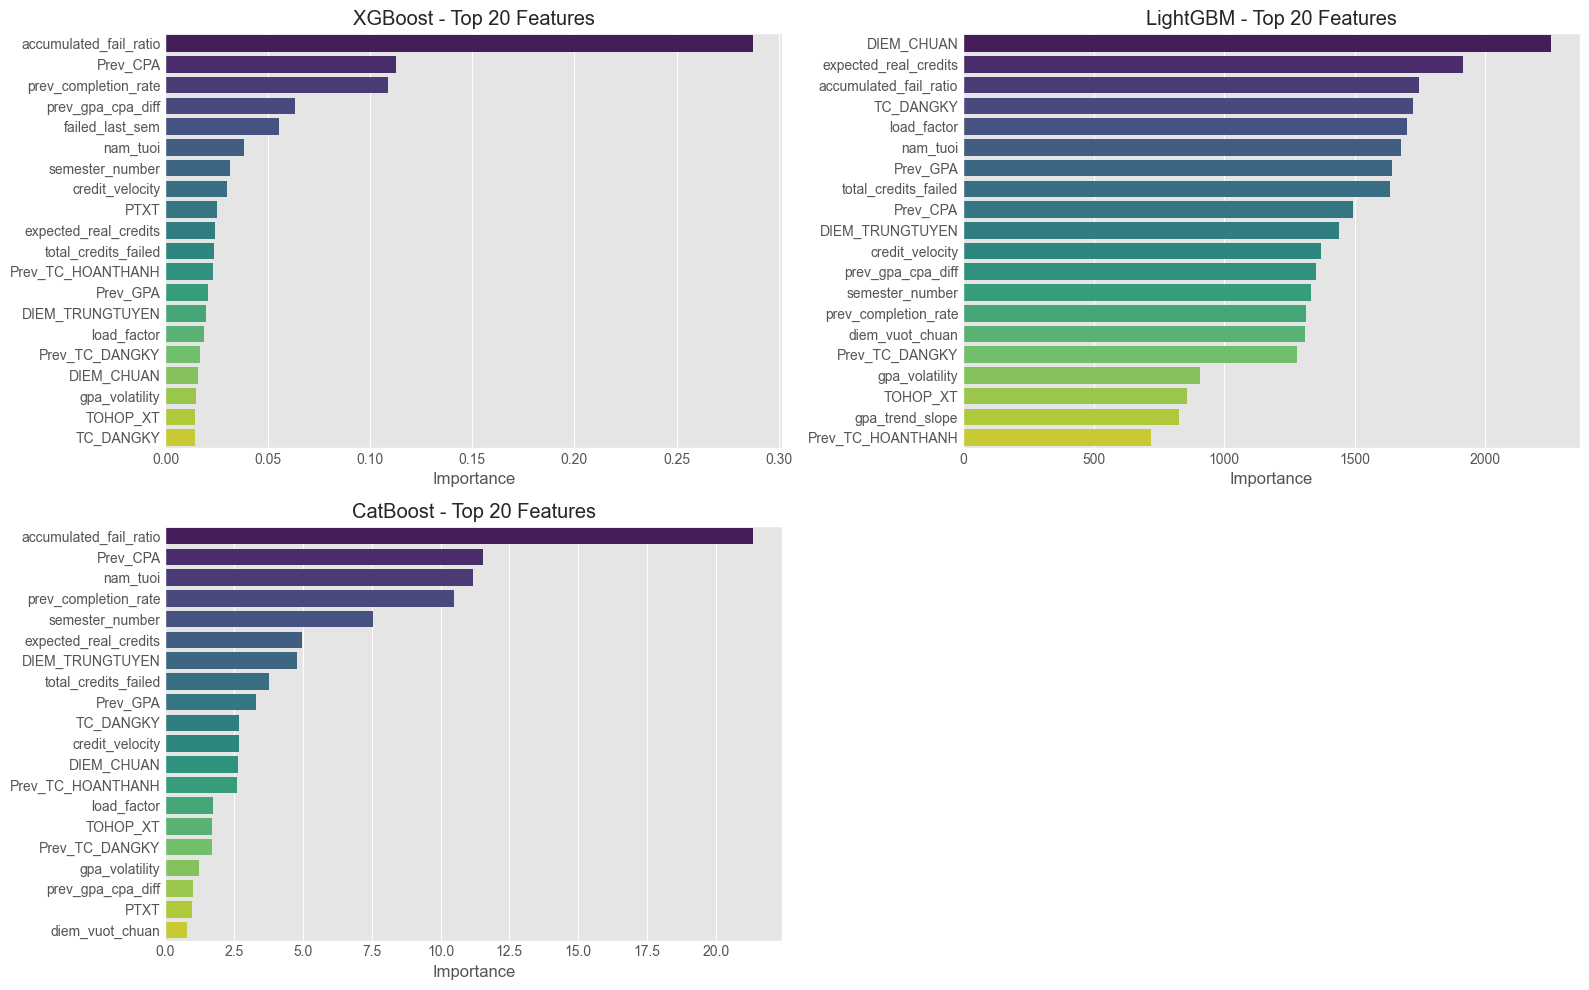

✓ XGBoost feature importance saved (24 features)
✓ LightGBM feature importance saved (24 features)
✓ CatBoost feature importance saved (24 features)


In [114]:
def plot_feature_importance_comparison(models, feature_cols, top_n=20):
    n_models = len(models)
    n_cols = 2
    n_rows = math.ceil(n_models / n_cols)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(8 * n_cols, 5 * n_rows)
    )

    axes = axes.flatten()

    for ax, (name, model) in zip(axes, models.items()):

        # Lấy feature importance
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        else:
            importance = model.get_feature_importance()

        df = (
            pd.DataFrame({
                'feature': feature_cols,
                'importance': importance
            })
            .sort_values('importance', ascending=False)
            .head(top_n)
        )

        sns.barplot(
            data=df,
            x='importance',
            y='feature',
            ax=ax,
            palette='viridis'
        )

        ax.set_title(f'{name} - Top {top_n} Features')
        ax.set_xlabel('Importance')
        ax.set_ylabel('')

    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()
models_for_fi = {
    'XGBoost': xgb_model,
    'LightGBM': lgb_model,
    'CatBoost': cat_model
}

# Plot
plot_feature_importance_comparison(
    models_for_fi,
    feature_cols,
    top_n=20
)
for name, model in models_for_fi.items():

    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        importance = model.get_feature_importance()

    fi_df = (
        pd.DataFrame({
            'feature': feature_cols,
            'importance': importance
        })
        .sort_values('importance', ascending=False)
        .reset_index(drop=True)
    )

    fi_df.to_csv(
        f'output/evaluation/feature_importance_{name}.csv',
        index=False
    )

    print(f"✓ {name} feature importance saved ({len(fi_df)} features)")


## 5. SHAP Analysis

In [115]:
print("\n" + "="*60)
print("SHAP ANALYSIS - XGBoost Model")
print("="*60)

# Use XGBoost model for SHAP analysis
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values (sample for speed)
sample_size = min(1000, len(X_valid_encoded))
X_sample = X_valid_encoded.sample(n=sample_size, random_state=RANDOM_STATE)

print(f"Calculating SHAP values for {sample_size} samples...")
shap_values = explainer.shap_values(X_sample)

print("✓ SHAP values calculated")


SHAP ANALYSIS - XGBoost Model
Calculating SHAP values for 1000 samples...
✓ SHAP values calculated



Creating SHAP summary plot...


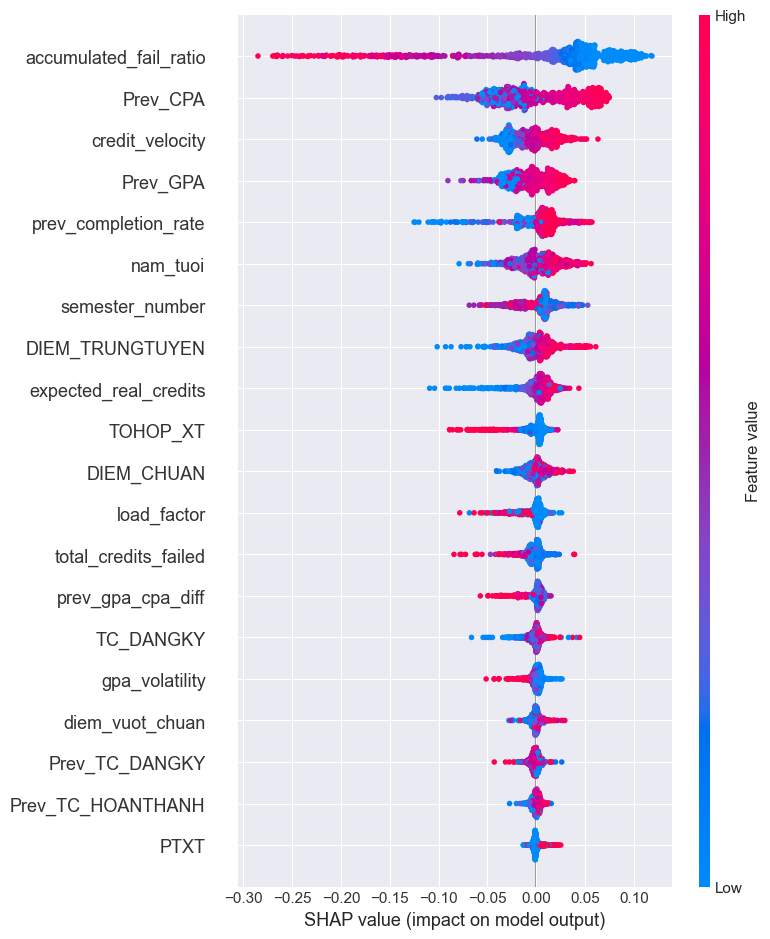

✓ SHAP summary plot saved


In [98]:
# SHAP Summary Plot
print("\nCreating SHAP summary plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, show=False)
plt.tight_layout()
plt.savefig('output/evaluation/shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ SHAP summary plot saved")


Creating SHAP feature importance plot...


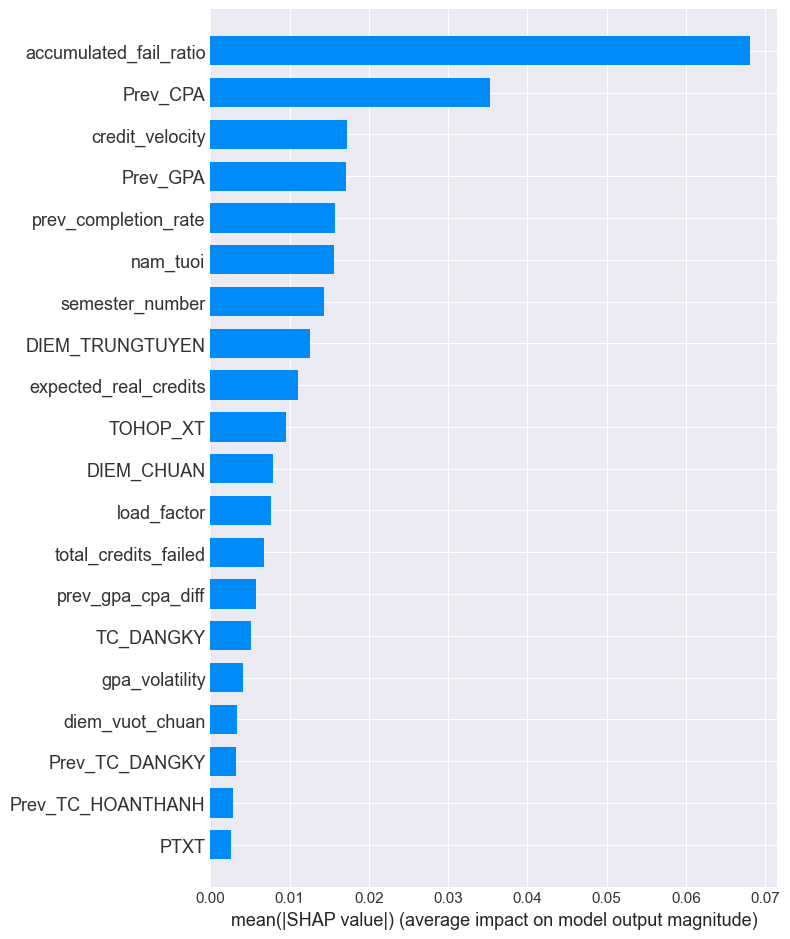

✓ SHAP feature importance saved


In [99]:
# SHAP Feature Importance (mean absolute SHAP values)
print("\nCreating SHAP feature importance plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('output/evaluation/shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ SHAP feature importance saved")


Creating SHAP dependence plots for top features...


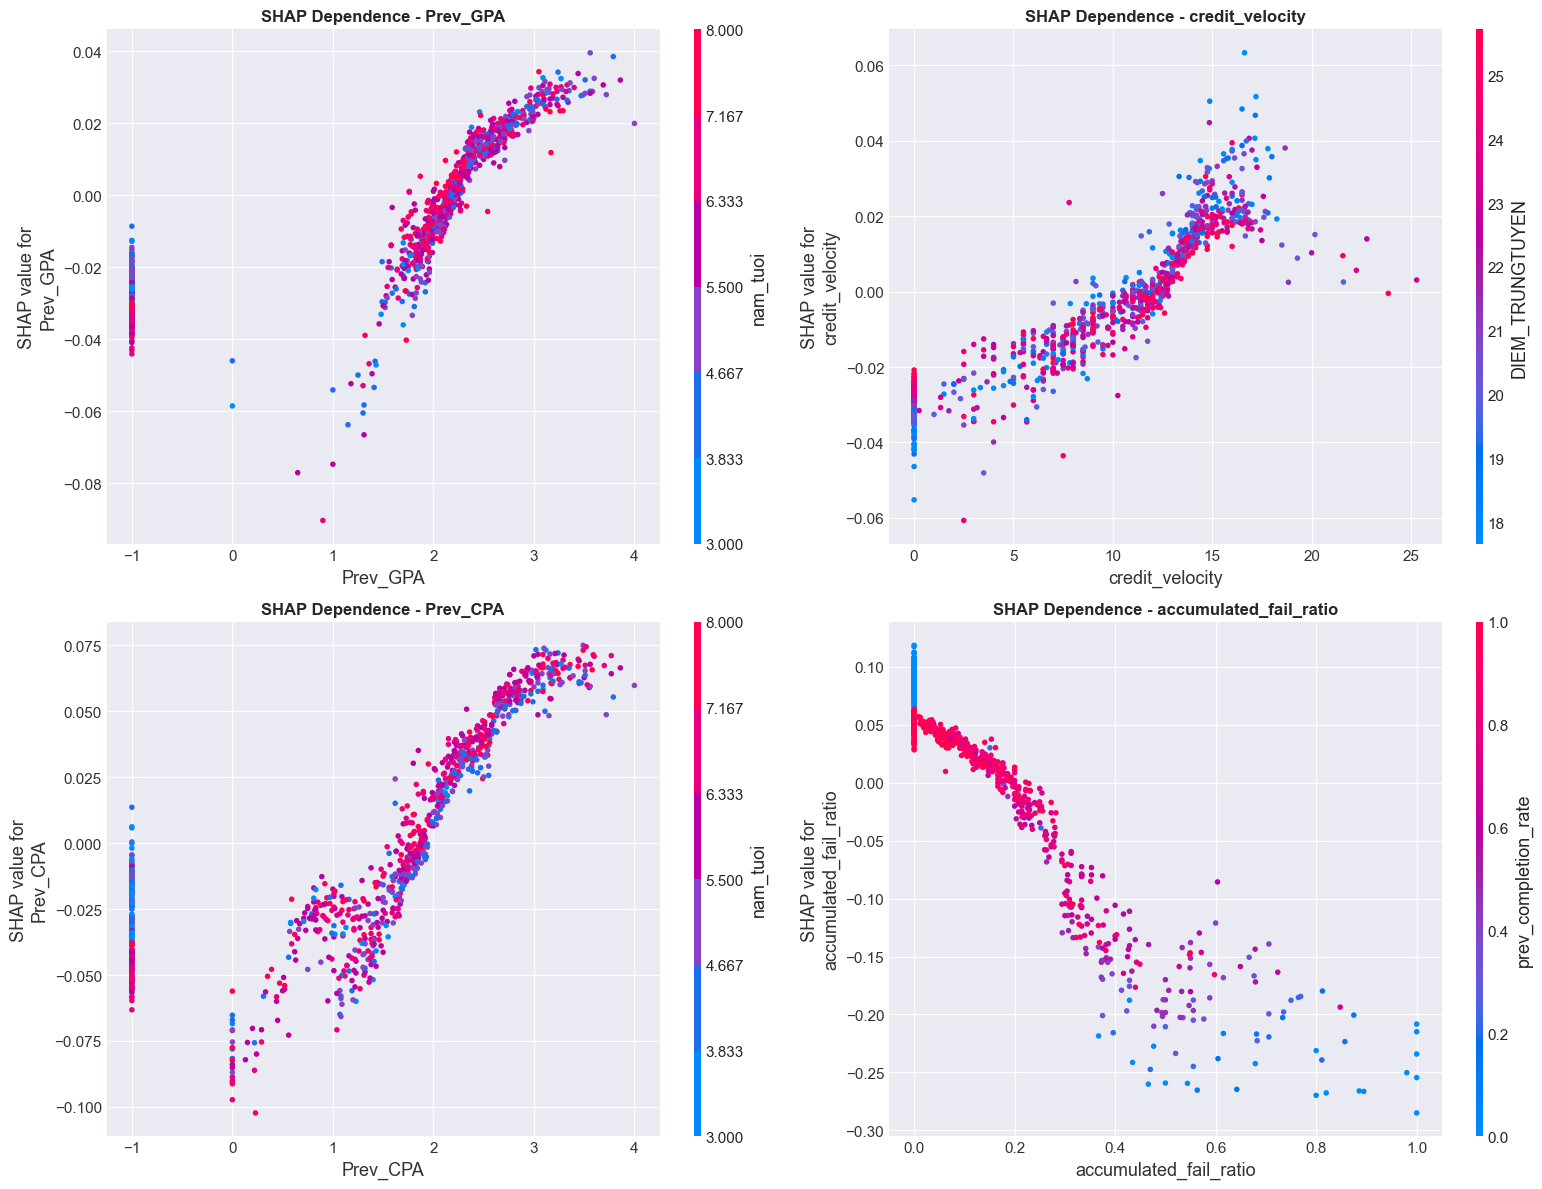

✓ SHAP dependence plots saved


In [100]:
# SHAP Dependence Plots for top features
print("\nCreating SHAP dependence plots for top features...")

# Get top 4 features by SHAP importance
shap_importance = np.abs(shap_values).mean(axis=0)
top_features_idx = np.argsort(shap_importance)[-4:]
top_features = [feature_cols[i] for i in top_features_idx]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(top_features):
    shap.dependence_plot(
        feature, shap_values, X_sample,
        feature_names=feature_cols,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f'SHAP Dependence - {feature}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('output/evaluation/shap_dependence_plots.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ SHAP dependence plots saved")

## 6. LIME Analysis

In [101]:
print("\n" + "="*60)
print("LIME ANALYSIS - Local Explanations")
print("="*60)

# Create LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_encoded.values,
    feature_names=feature_cols,
    mode='regression',
    random_state=RANDOM_STATE
)

print("✓ LIME explainer created")


LIME ANALYSIS - Local Explanations
✓ LIME explainer created



Explaining 3 cases with LIME...

Best case (index 23):
  Actual: 23.00
  Predicted: 23.00
  Error: 0.00


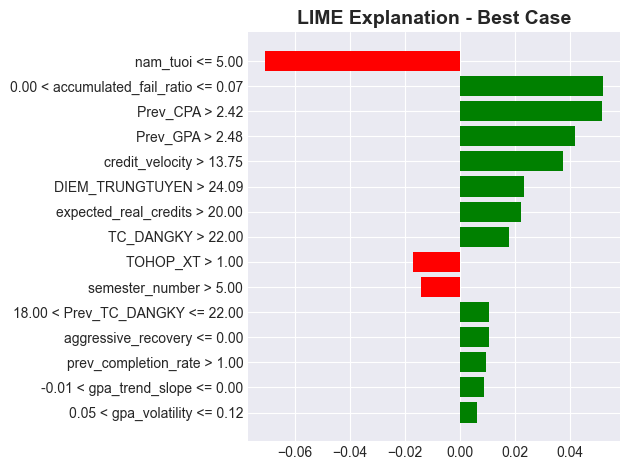


Worst case (index 17104):
  Actual: 1.00
  Predicted: 29.01
  Error: 28.01


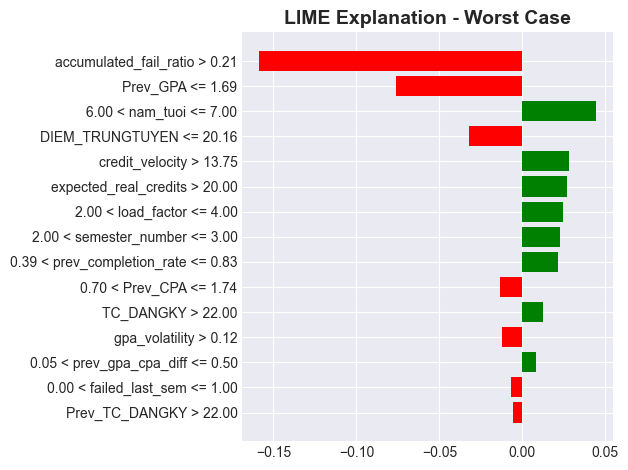


Median case (index 7623):
  Actual: 14.00
  Predicted: 15.70
  Error: 1.70


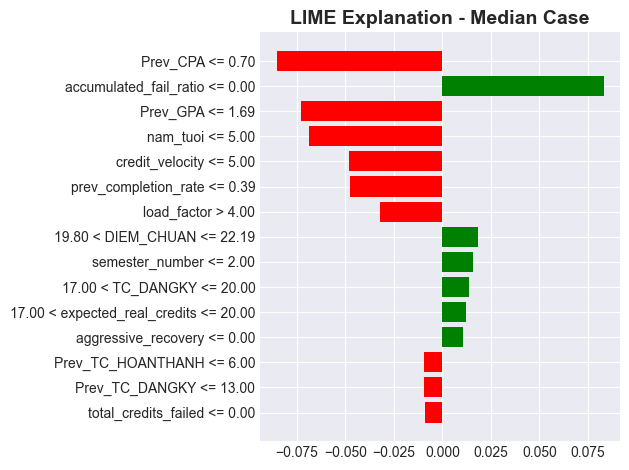


✓ LIME explanations saved


In [102]:
# Explain several predictions
def explain_with_lime(model, explainer, X_data, instance_idx, num_features=15):
    """
    Explain a single prediction using LIME
    """
    instance = X_data.iloc[instance_idx].values
    
    # Get explanation
    exp = explainer.explain_instance(
        instance,
        model.predict,
        num_features=num_features
    )
    
    return exp

# Select interesting cases to explain
# 1. Best prediction (closest to actual)
# 2. Worst prediction (furthest from actual)
# 3. Random middle case

errors = np.abs(y_valid_credits - predictions['XGBoost'])
best_idx = np.argmin(errors)
worst_idx = np.argmax(errors)
median_idx = np.argsort(errors)[len(errors)//2]

cases = {
    'Best': best_idx,
    'Worst': worst_idx,
    'Median': median_idx
}

print(f"\nExplaining {len(cases)} cases with LIME...")

for case_name, idx in cases.items():
    print(f"\n{case_name} case (index {idx}):")
    print(f"  Actual: {y_valid_credits[idx]:.2f}")
    print(f"  Predicted: {predictions['XGBoost'][idx]:.2f}")
    print(f"  Error: {errors[idx]:.2f}")
    
    exp = explain_with_lime(xgb_model, lime_explainer, X_valid_encoded, idx)
    
    # Visualize
    fig = exp.as_pyplot_figure()
    plt.title(f'LIME Explanation - {case_name} Case', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'output/evaluation/lime_explanation_{case_name.lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save HTML report
    exp.save_to_file(f'output/evaluation/lime_explanation_{case_name.lower()}.html')
    
print("\n✓ LIME explanations saved")

## 7. Hyperparameter Optimization with Optuna

In [103]:
print("\n" + "="*60)
print("HYPERPARAMETER OPTIMIZATION - XGBoost with Optuna")
print("="*60)

def objective(trial):
    """
    Objective function for Optuna optimization
    """
    params = {
        'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'objective': 'reg:squarederror',
        'n_jobs': -1,
        'random_state': RANDOM_STATE,
    }
    
    # Train model
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train_encoded, y_train,
        eval_set=[(X_valid_encoded, y_valid)],
        verbose=False
    )
    
    # Predict and evaluate
    y_pred_rate = model.predict(X_valid_encoded)
    y_pred_rate = np.clip(y_pred_rate, 0, 1)
    y_pred_credits = y_pred_rate * valid_credits_dangky
    y_pred_credits = np.minimum(y_pred_credits, valid_credits_dangky)
    
    rmse = np.sqrt(mean_squared_error(y_valid_credits, y_pred_credits))
    
    return rmse

# Create study
study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=RANDOM_STATE)
)

print("\nRunning optimization (50 trials)...")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "="*60)
print("OPTIMIZATION COMPLETED")
print("="*60)
print(f"Best RMSE: {study.best_value:.4f}")
print("\nBest parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2026-02-03 23:29:55,224] A new study created in memory with name: no-name-4738e6f0-3e71-4148-a659-5b812f44ad65



HYPERPARAMETER OPTIMIZATION - XGBoost with Optuna

Running optimization (50 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-03 23:30:01,457] Trial 0 finished with value: 3.846028925428636 and parameters: {'learning_rate': 0.021854305348131316, 'max_depth': 10, 'subsample': 0.892797576724562, 'colsample_bytree': 0.8394633936788146, 'reg_alpha': 1.5601864044243652, 'reg_lambda': 1.5599452033620265, 'min_child_weight': 1, 'gamma': 4.330880728874676}. Best is trial 0 with value: 3.846028925428636.
[I 2026-02-03 23:30:07,589] Trial 1 finished with value: 3.7813383632971145 and parameters: {'learning_rate': 0.0320501755284444, 'max_depth': 8, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 8.324426408004218, 'reg_lambda': 2.1233911067827616, 'min_child_weight': 2, 'gamma': 0.9170225492671691}. Best is trial 1 with value: 3.7813383632971145.
[I 2026-02-03 23:30:14,159] Trial 2 finished with value: 3.8115485355753616 and parameters: {'learning_rate': 0.0186909009331792, 'max_depth': 7, 'subsample': 0.7727780074568463, 'colsample_bytree': 0.7164916560792167, 'reg_alpha

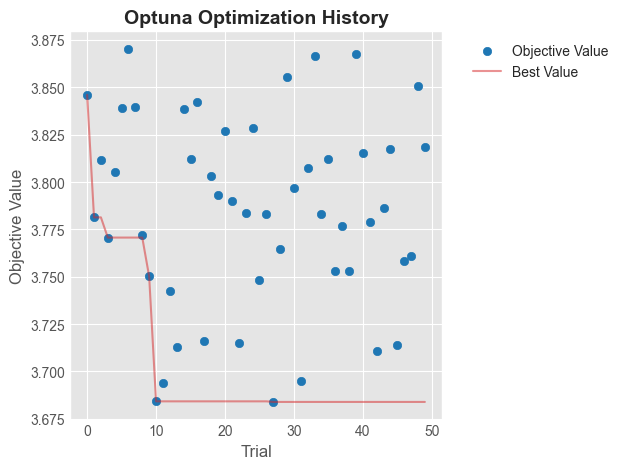

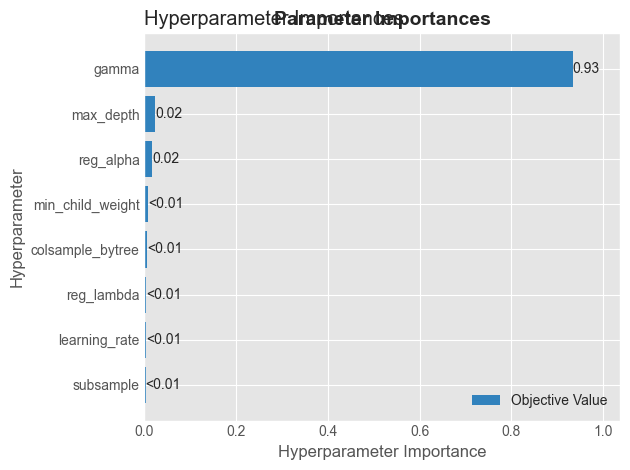

✓ Optimization visualizations saved


In [105]:
# Visualize optimization history
fig = optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Optuna Optimization History', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('output/evaluation/optuna_optimization_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualize parameter importances
fig = optuna.visualization.matplotlib.plot_param_importances(study)
plt.title('Parameter Importances', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('output/evaluation/optuna_param_importances.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Optimization visualizations saved")

In [116]:
# Train final model with best parameters
print("\nTraining final optimized model...")

best_params = study.best_params.copy()
best_params.update({
    'n_estimators': 2000,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'random_state': RANDOM_STATE,
})

xgb_optimized = xgb.XGBRegressor(**best_params)
xgb_optimized.fit(
    X_train_encoded, y_train,
    eval_set=[(X_valid_encoded, y_valid)],
    verbose=100
)

y_pred_optimized = xgb_optimized.predict(X_valid_encoded)
result, pred_credits = evaluate_model('XGBoost (Optimized)', y_pred_optimized, y_valid_credits, valid_credits_dangky)
results.append(result)
predictions['XGBoost (Optimized)'] = pred_credits

print(f"\nOptimized XGBoost Results:")
print(f"  RMSE: {result['RMSE']:.4f}")
print(f"  MAE:  {result['MAE']:.4f}")
print(f"  R2:   {result['R2']:.4f}")
print(f"  Accuracy: {result['Accuracy']:.2f}%")

# Compare with default
default_result = [r for r in results if r['Model'] == 'XGBoost'][0]
print(f"\nImprovement over default:")
print(f"  RMSE: {default_result['RMSE'] - result['RMSE']:.4f} ({((default_result['RMSE'] - result['RMSE'])/default_result['RMSE']*100):.2f}%)")


Training final optimized model...
[0]	validation_0-rmse:0.25690
[100]	validation_0-rmse:0.19836
[200]	validation_0-rmse:0.19613
[300]	validation_0-rmse:0.19485
[400]	validation_0-rmse:0.19418
[500]	validation_0-rmse:0.19376
[600]	validation_0-rmse:0.19348
[700]	validation_0-rmse:0.19328
[800]	validation_0-rmse:0.19314
[900]	validation_0-rmse:0.19304
[1000]	validation_0-rmse:0.19296
[1100]	validation_0-rmse:0.19290
[1200]	validation_0-rmse:0.19286
[1300]	validation_0-rmse:0.19284
[1400]	validation_0-rmse:0.19283
[1500]	validation_0-rmse:0.19282
[1600]	validation_0-rmse:0.19285
[1700]	validation_0-rmse:0.19287
[1800]	validation_0-rmse:0.19287
[1900]	validation_0-rmse:0.19286
[1999]	validation_0-rmse:0.19286

Optimized XGBoost Results:
  RMSE: 3.6839
  MAE:  2.5285
  R2:   0.6967
  Accuracy: 33.19%

Improvement over default:
  RMSE: -0.0066 (-0.18%)


## 8. Complete Training Pipeline Summary


FINAL MODEL COMPARISON - ALL MODELS
                          Model     RMSE      MAE       R2  Accuracy
                Simple Ensemble 3.669588 2.528791 0.699012 32.526246
                        XGBoost 3.677320 2.523515 0.697743 32.999149
                       LightGBM 3.678851 2.538735 0.697491 32.313440
Blending (XGB + LGB + CatBoost) 3.679324 2.540667 0.697413 32.157382
            XGBoost (Optimized) 3.683911 2.528534 0.696658 33.188310
                       CatBoost 3.684645 2.544797 0.696537 32.242504


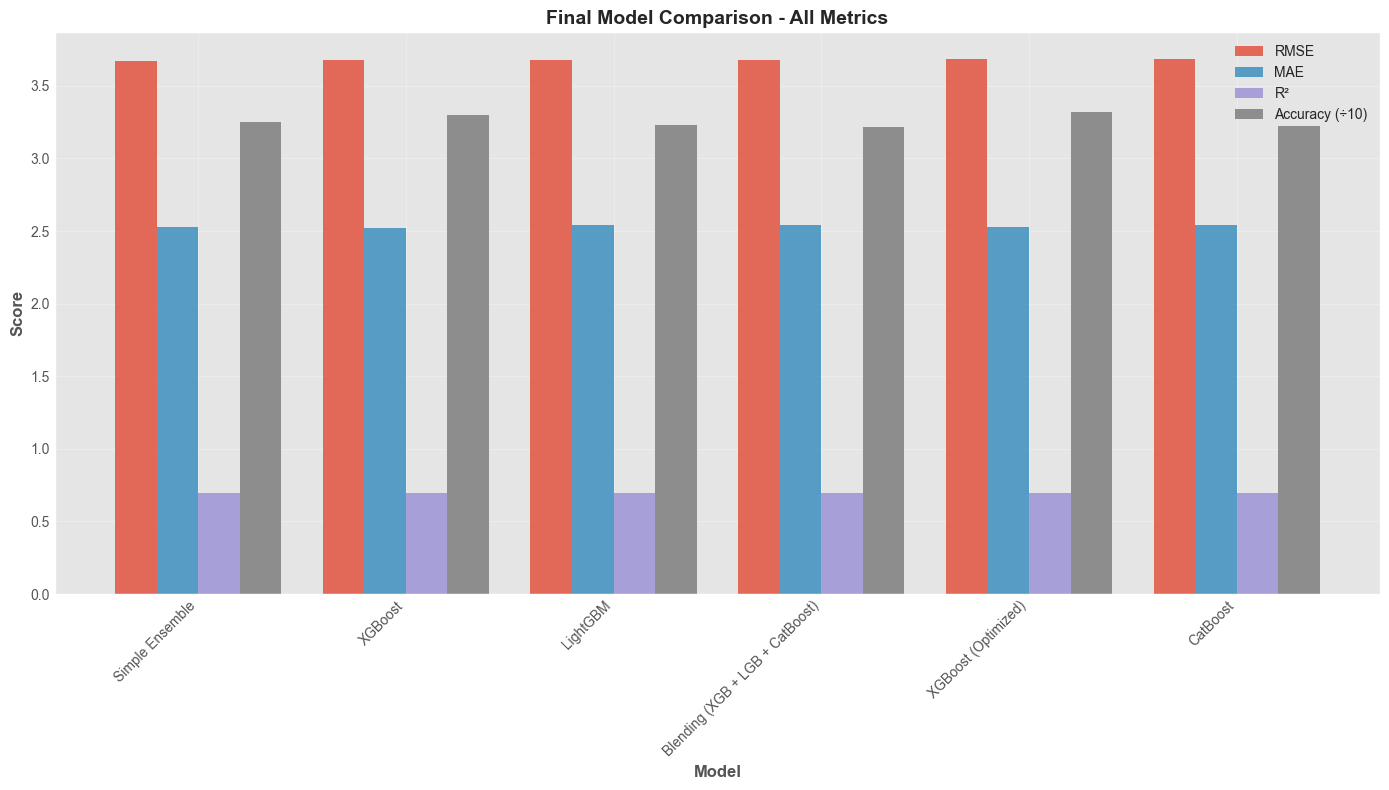


✓ Final comparison saved


In [117]:
# Final comparison including optimized model
final_results_df = pd.DataFrame(results)
final_results_df = final_results_df.sort_values('RMSE')

print("\n" + "="*80)
print("FINAL MODEL COMPARISON - ALL MODELS")
print("="*80)
print(final_results_df.to_string(index=False))
print("="*80)

# Save final results
final_results_df.to_csv('output/evaluation/final_model_comparison.csv', index=False)

# Visualize final comparison
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(final_results_df))
width = 0.2

ax.bar(x - 1.5*width, final_results_df['RMSE'], width, label='RMSE', alpha=0.8)
ax.bar(x - 0.5*width, final_results_df['MAE'], width, label='MAE', alpha=0.8)
ax.bar(x + 0.5*width, final_results_df['R2'], width, label='R²', alpha=0.8)
ax.bar(x + 1.5*width, final_results_df['Accuracy']/10, width, label='Accuracy (÷10)', alpha=0.8)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Final Model Comparison - All Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(final_results_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/evaluation/final_comparison_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Final comparison saved")

## 9. Predictions Distribution Analysis

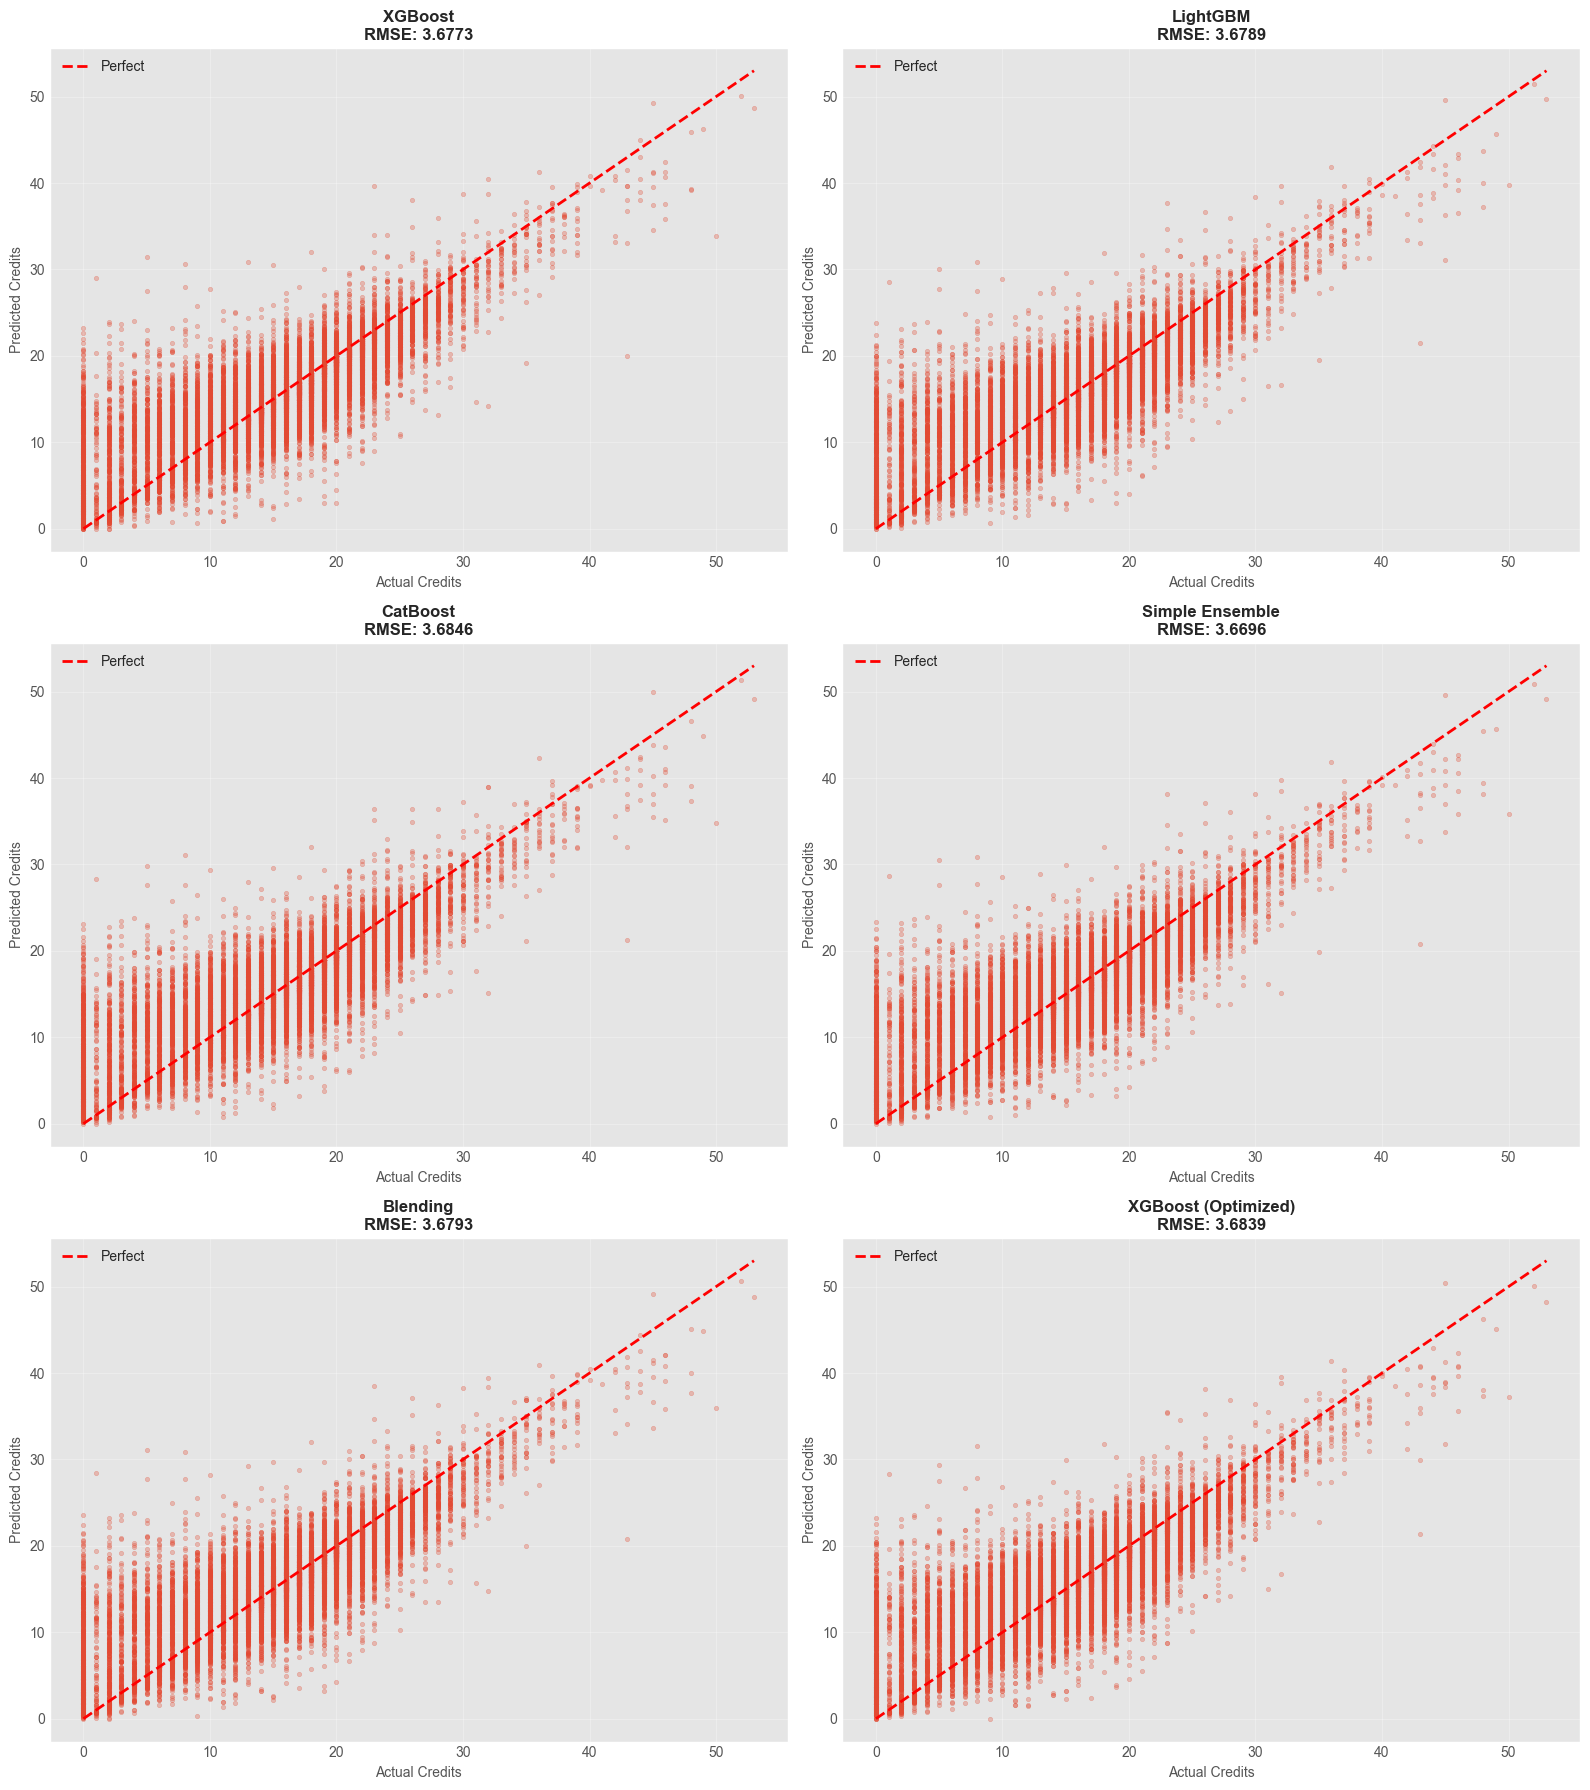

✓ Prediction distributions saved


In [118]:
# Analyze prediction distributions
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.ravel()

for idx, (name, preds) in enumerate(predictions.items()):
    if idx >= 6:
        break
        
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(y_valid_credits, preds, alpha=0.3, s=10)
    
    # Perfect prediction line
    min_val = min(y_valid_credits.min(), preds.min())
    max_val = max(y_valid_credits.max(), preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
    
    # Add RMSE to title
    rmse = np.sqrt(mean_squared_error(y_valid_credits, preds))
    ax.set_title(f'{name}\nRMSE: {rmse:.4f}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Actual Credits', fontsize=10)
    ax.set_ylabel('Predicted Credits', fontsize=10)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/evaluation/predictions_scatter_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Prediction distributions saved")

## 10. Error Analysis

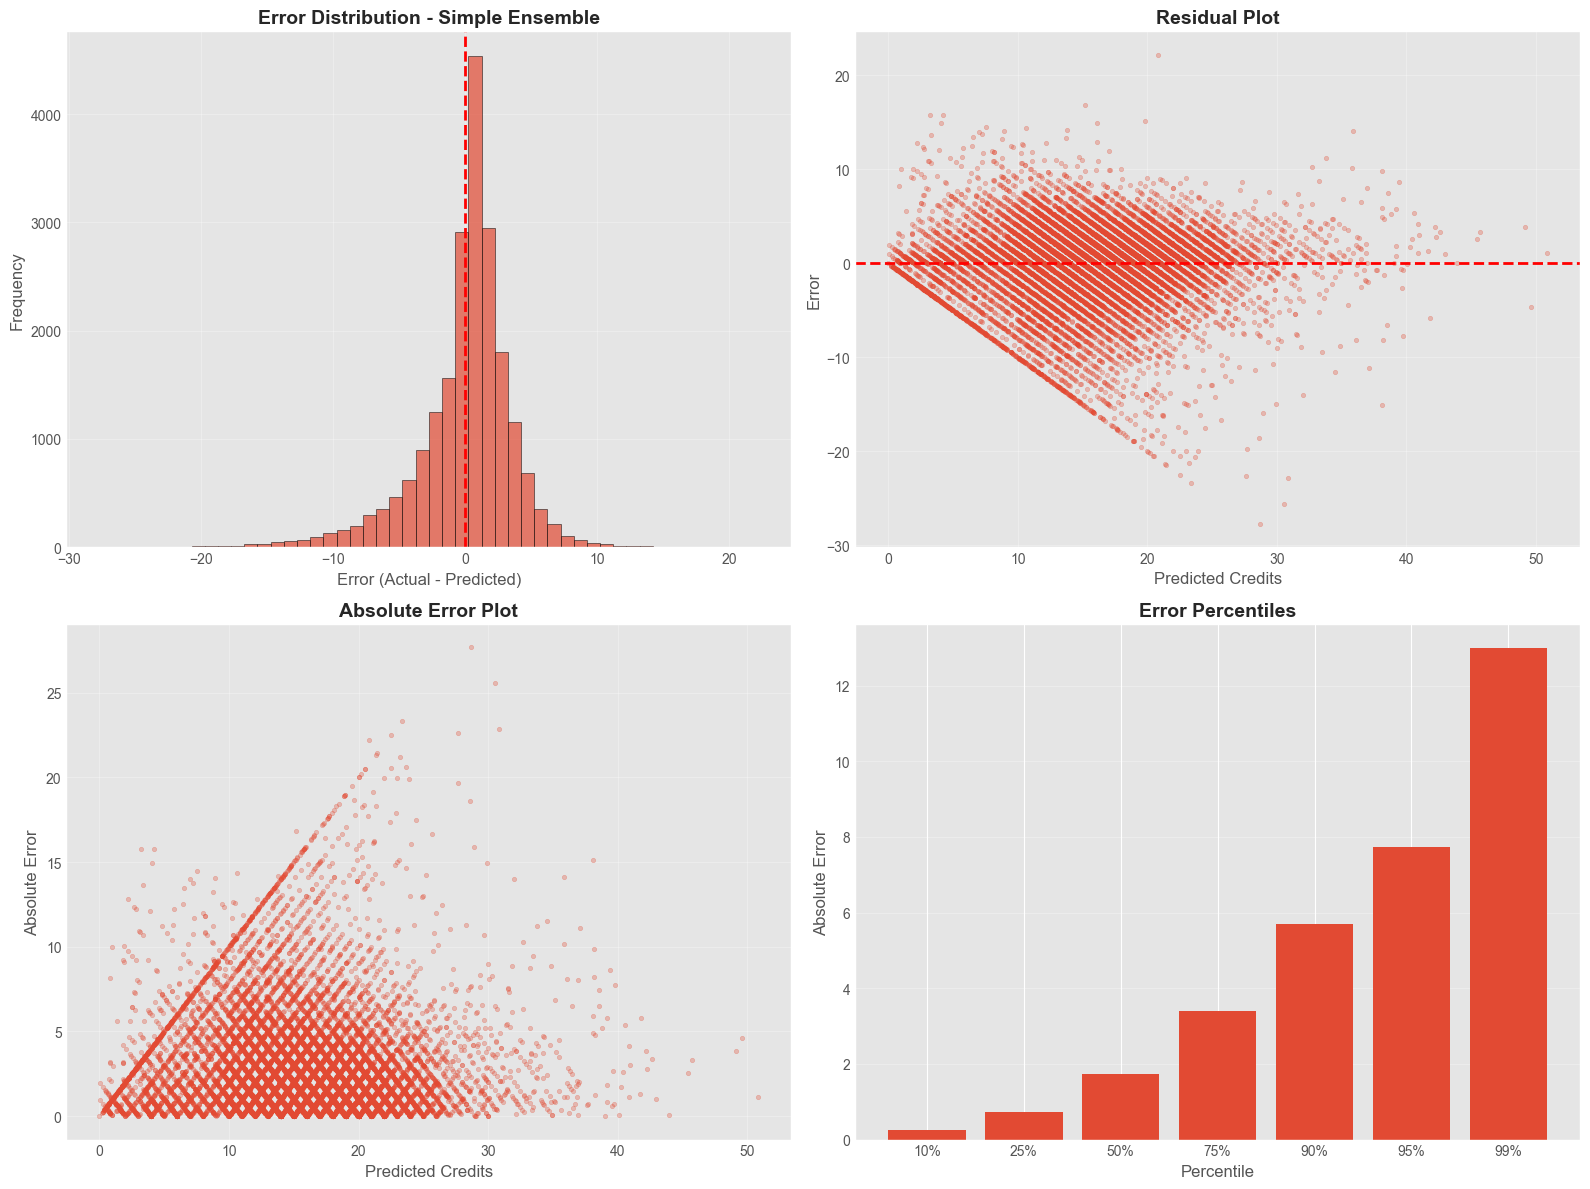


Error Statistics - Simple Ensemble:
  Mean Error: -0.0079
  Std Error: 3.6696
  Mean Absolute Error: 2.5288
  Median Absolute Error: 1.7222

Error Percentiles:
  10th percentile: 0.2601
  25th percentile: 0.7418
  50th percentile: 1.7222
  75th percentile: 3.3934
  90th percentile: 5.6977
  95th percentile: 7.7253
  99th percentile: 12.9833

✓ Error analysis complete


In [119]:
# Analyze errors for best model
best_model_name = final_results_df.iloc[0]['Model']
best_predictions = predictions[best_model_name]

errors = y_valid_credits - best_predictions

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Error distribution
axes[0, 0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[0, 0].set_xlabel('Error (Actual - Predicted)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title(f'Error Distribution - {best_model_name}', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Error vs Predicted
axes[0, 1].scatter(best_predictions, errors, alpha=0.3, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Credits', fontsize=12)
axes[0, 1].set_ylabel('Error', fontsize=12)
axes[0, 1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Absolute error vs Predicted
abs_errors = np.abs(errors)
axes[1, 0].scatter(best_predictions, abs_errors, alpha=0.3, s=10)
axes[1, 0].set_xlabel('Predicted Credits', fontsize=12)
axes[1, 0].set_ylabel('Absolute Error', fontsize=12)
axes[1, 0].set_title('Absolute Error Plot', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Error percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
error_percentiles = np.percentile(abs_errors, percentiles)
axes[1, 1].bar(range(len(percentiles)), error_percentiles, tick_label=[f'{p}%' for p in percentiles])
axes[1, 1].set_xlabel('Percentile', fontsize=12)
axes[1, 1].set_ylabel('Absolute Error', fontsize=12)
axes[1, 1].set_title('Error Percentiles', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'output/evaluation/error_analysis_{best_model_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
plt.show()

# Print error statistics
print(f"\nError Statistics - {best_model_name}:")
print(f"  Mean Error: {errors.mean():.4f}")
print(f"  Std Error: {errors.std():.4f}")
print(f"  Mean Absolute Error: {abs_errors.mean():.4f}")
print(f"  Median Absolute Error: {np.median(abs_errors):.4f}")
print(f"\nError Percentiles:")
for p, val in zip(percentiles, error_percentiles):
    print(f"  {p}th percentile: {val:.4f}")

print("\n✓ Error analysis complete")

## 11. Save Best Model

In [126]:
import joblib
from pathlib import Path

Path('models').mkdir(exist_ok=True)

if best_model_name == 'Simple Ensemble':
    fallback_model_name = 'LightGBM'   # ví dụ
    best_model = models[fallback_model_name]
    save_name = fallback_model_name
else:
    best_model = models[best_model_name]
    save_name = best_model_name

# Save model
model_path = Path('models') / f'best_model_{save_name.replace(" ", "_")}.pkl'
joblib.dump(best_model, model_path)

# Save feature info
feature_info = {
    'feature_cols': feature_cols,
    'categorical_cols': categorical_cols,
    'label_encoders': label_encoders
}
joblib.dump(feature_info, Path('models') / 'feature_info.pkl')

print(f"✓ Best model saved: {model_path}")
print("✓ Feature info saved: models/feature_info.pkl")


✓ Best model saved: models\best_model_LightGBM.pkl
✓ Feature info saved: models/feature_info.pkl


## 12. Summary Report

In [127]:
print("\n" + "="*80)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*80)

print("\n1. MODELS TRAINED:")
for model_name in models.keys():
    print(f"   ✓ {model_name}")

print("\n2. BEST MODEL:")
print(f"   {best_model_name}")
best_result = final_results_df.iloc[0]
print(f"   RMSE: {best_result['RMSE']:.4f}")
print(f"   MAE:  {best_result['MAE']:.4f}")
print(f"   R²:   {best_result['R2']:.4f}")
print(f"   Accuracy: {best_result['Accuracy']:.2f}%")

print("\n3. ANALYSES PERFORMED:")
print("   ✓ Feature Importance (all models)")
print("   ✓ SHAP Analysis (summary, importance, dependence plots)")
print("   ✓ LIME Analysis (3 cases: best, worst, median)")
print("   ✓ Hyperparameter Optimization (Optuna)")
print("   ✓ Error Analysis")
print("   ✓ Prediction Distribution Analysis")

print("\n4. FILES SAVED:")
saved_files = [
    'output/evaluation/model_comparison_results.csv',
    'output/evaluation/model_comparison_charts.png',
    'output/evaluation/feature_importance_comparison.png',
    'output/evaluation/shap_summary_plot.png',
    'output/evaluation/shap_feature_importance.png',
    'output/evaluation/shap_dependence_plots.png',
    'output/evaluation/lime_explanation_*.png/html',
    'output/evaluation/optuna_optimization_history.png',
    'output/evaluation/optuna_param_importances.png',
    'output/evaluation/final_model_comparison.csv',
    'output/evaluation/final_comparison_chart.png',
    'output/evaluation/predictions_scatter_all_models.png',
    f'output/evaluation/error_analysis_{best_model_name.replace(" ", "_")}.png',
    f'models/best_model_{best_model_name.replace(" ", "_")}.pkl',
    'models/feature_info.pkl'
]

for file in saved_files:
    print(f"   ✓ {file}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nAll results saved to output/evaluation/")
print("Best model saved to models/")


COMPREHENSIVE ANALYSIS SUMMARY

1. MODELS TRAINED:
   ✓ XGBoost
   ✓ LightGBM
   ✓ CatBoost

2. BEST MODEL:
   Simple Ensemble
   RMSE: 3.6696
   MAE:  2.5288
   R²:   0.6990
   Accuracy: 32.53%

3. ANALYSES PERFORMED:
   ✓ Feature Importance (all models)
   ✓ SHAP Analysis (summary, importance, dependence plots)
   ✓ LIME Analysis (3 cases: best, worst, median)
   ✓ Hyperparameter Optimization (Optuna)
   ✓ Error Analysis
   ✓ Prediction Distribution Analysis

4. FILES SAVED:
   ✓ output/evaluation/model_comparison_results.csv
   ✓ output/evaluation/model_comparison_charts.png
   ✓ output/evaluation/feature_importance_comparison.png
   ✓ output/evaluation/shap_summary_plot.png
   ✓ output/evaluation/shap_feature_importance.png
   ✓ output/evaluation/shap_dependence_plots.png
   ✓ output/evaluation/lime_explanation_*.png/html
   ✓ output/evaluation/optuna_optimization_history.png
   ✓ output/evaluation/optuna_param_importances.png
   ✓ output/evaluation/final_model_comparison.csv
   ✓